In [15]:
from __future__ import division, print_function, absolute_import
import collections
import os
import random
import urllib
import zipfile
from urllib.request import urlretrieve
import numpy as np
import tensorflow as tf
tf.compat.v1.reset_default_graph


learning_rate = 0.1
batch_size = 128
num_steps = 10000
display_step = 1000
eval_step = 500


eval_words = ['楊', '二', '長', '谷', '笑']


embedding_size = 128 
max_vocabulary_size = 50000 
min_occurrence = 10  
skip_window = 1 
num_skips = 2 
num_sampled = 64 

In [30]:
## write your code here
import jieba
with open('./romance_condor_heroes.txt' , "r" , encoding="utf-8") as f:
    f = f.read()

text_words = [x for x in f if x != ' ' and x != '\n']
print(text_words[:5])
print('Data size %d' % len(text_words))

['“', '越', '女', '采', '蓮']
Data size 948199


In [13]:
print(text_words[:5])

['“', '越', '女', '采', '蓮']


In [26]:
list(enumerate(count[:10]))

[(0, ('UNK', 5003)),
 (1, ('，', 70583)),
 (2, ('。', 21619)),
 (3, ('一', 15645)),
 (4, ('不', 14690)),
 (5, ('是', 12315)),
 (6, ('“', 12068)),
 (7, ('”', 12047)),
 (8, ('的', 11872)),
 (9, ('道', 11813))]

In [28]:
word2id['道']

9

In [16]:
## write your code here
count = [('UNK', -1)]

count.extend(collections.Counter(text_words).most_common(max_vocabulary_size - 1))

for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        break

vocabulary_size = len(count)

word2id = dict()
for i, (word, _) in enumerate(count):
    word2id[word] = i

data = list()
unk_count = 0
for word in text_words:

    index = word2id.get(word, 0)
    if index == 0:
        unk_count += 1
    data.append(index)
    
count[0] = ('UNK', unk_count)
id2word = dict(zip(word2id.values(), word2id.keys()))


print("Words count:", len(text_words))
print("Unique words:", len(set(text_words)))
print("Vocabulary size:", vocabulary_size)
print("Most common words:", count[:10])

Words count: 954977
Unique words: 3964
Vocabulary size: 2494
Most common words: [('UNK', 5003), ('，', 70583), ('。', 21619), ('一', 15645), ('不', 14690), ('是', 12315), ('“', 12068), ('”', 12047), ('的', 11872), ('道', 11813)]


In [17]:
data_index = 0

def next_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer.extend(data[0:span])
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1

    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [18]:

with tf.device('/cpu:0'):

    embedding = tf.Variable(tf.random.normal([vocabulary_size, embedding_size]))

    nce_weights = tf.Variable(tf.random.normal([vocabulary_size, embedding_size]))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

def get_embedding(x):
    with tf.device('/cpu:0'):

        x_embed = tf.nn.embedding_lookup(embedding, x)
        return x_embed

def nce_loss(x_embed, y):
    with tf.device('/cpu:0'):

        y = tf.cast(y, tf.int64)
        loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,
                           biases=nce_biases,
                           labels=y,
                           inputs=x_embed,
                           num_sampled=num_sampled,
                           num_classes=vocabulary_size))
        return loss

# 评估
def evaluate(x_embed):
    with tf.device('/cpu:0'):

        x_embed = tf.cast(x_embed, tf.float32)
        x_embed_norm = x_embed / tf.sqrt(tf.reduce_sum(tf.square(x_embed)))
        embedding_norm = embedding / tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True), tf.float32)
        cosine_sim_op = tf.matmul(x_embed_norm, embedding_norm, transpose_b=True)
        return cosine_sim_op


optimizer = tf.optimizers.SGD(learning_rate)

In [19]:
def run_optimization(x, y):
    with tf.device('/cpu:0'):

        with tf.GradientTape() as g:
            emb = get_embedding(x)
            loss = nce_loss(emb, y)

        gradients = g.gradient(loss, [embedding, nce_weights, nce_biases])

        optimizer.apply_gradients(zip(gradients, [embedding, nce_weights, nce_biases]))

In [20]:

x_test = np.array([word2id[w] for w in eval_words])

for step in range(1, num_steps + 1):
    ## write your code here
    batch_x, batch_y = next_batch(batch_size, num_skips, skip_window)
    run_optimization(batch_x, batch_y)

    if step % display_step == 0 or step == 1:
        loss = nce_loss(get_embedding(batch_x), batch_y)
        print("step: %i, loss: %f" % (step, loss))

    if step % eval_step == 0 or step == 1:
        print("Evaluation...")
        sim = evaluate(get_embedding(x_test)).numpy()
        for i in range(len(eval_words)):
            top_k = 8 
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]
            log_str = '"%s" nearest neighbors:' % eval_words[i]
            for k in range(top_k):
                log_str = '%s %s,' % (log_str, id2word[nearest[k]])
            print(log_str)

step: 1, loss: 389.737244
Evaluation...
"楊" nearest neighbors: 姬, 歐, 紋, 肖, 俱, 渾, 仙, 勸,
"二" nearest neighbors: 咳, 清, 摸, 林, 遍, 潛, 妨, 泊,
"長" nearest neighbors: 豔, 亢, 川, 喀, 精, 喃, 店, 以,
"谷" nearest neighbors: 駝, 柱, 雞, 乳, 宿, 栽, 尋, 乾,
"笑" nearest neighbors: 泊, 彩, 第, 量, 泄, 備, 衰, 鳳,
Evaluation...
"楊" nearest neighbors: 姬, 紋, 歐, 肖, 俱, 渾, 仙, 勸,
"二" nearest neighbors: 清, 你, 咳, 林, 頭, 妨, 潛, 泊,
"長" nearest neighbors: 豔, 亢, 川, 喀, 處, 以, 芙, 喃,
"谷" nearest neighbors: 駝, 柱, 雞, 乳, 宿, 栽, 躺, 乾,
"笑" nearest neighbors: 泊, 道, 雙, “, 窯, 衰, 彩, 是,
step: 1000, loss: 110.859772
Evaluation...
"楊" nearest neighbors: 了, 道, 。, 一, 人, 不, 是, 你,
"二" nearest neighbors: 你, 著,  , 頭, 一, 不, 到, 清,
"長" nearest neighbors: 過, 我, 了, 那, 去, 處, 以, ？,
"谷" nearest neighbors: 駝, 柱, 雞, 乳, 宿, 栽, 躺, 乾,
"笑" nearest neighbors: “, 道, ”, 是, UNK, 雙, 不, 見,
Evaluation...
"楊" nearest neighbors: 了, 是, 人, 。, 道, 一, ：, 的,
"二" nearest neighbors: 你,  , 頭, 著, 到, 清, 道, 一,
"長" nearest neighbors: 過, 我, 那, 了, 去, 處, ？, 得,
"谷" nearest neighbors: 駝, 雞, 柱, 乳, 宿, 栽, 

C:\Users\Student\anaconda3\envs\AI_Course\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Student\anaconda3\envs\AI_Course\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


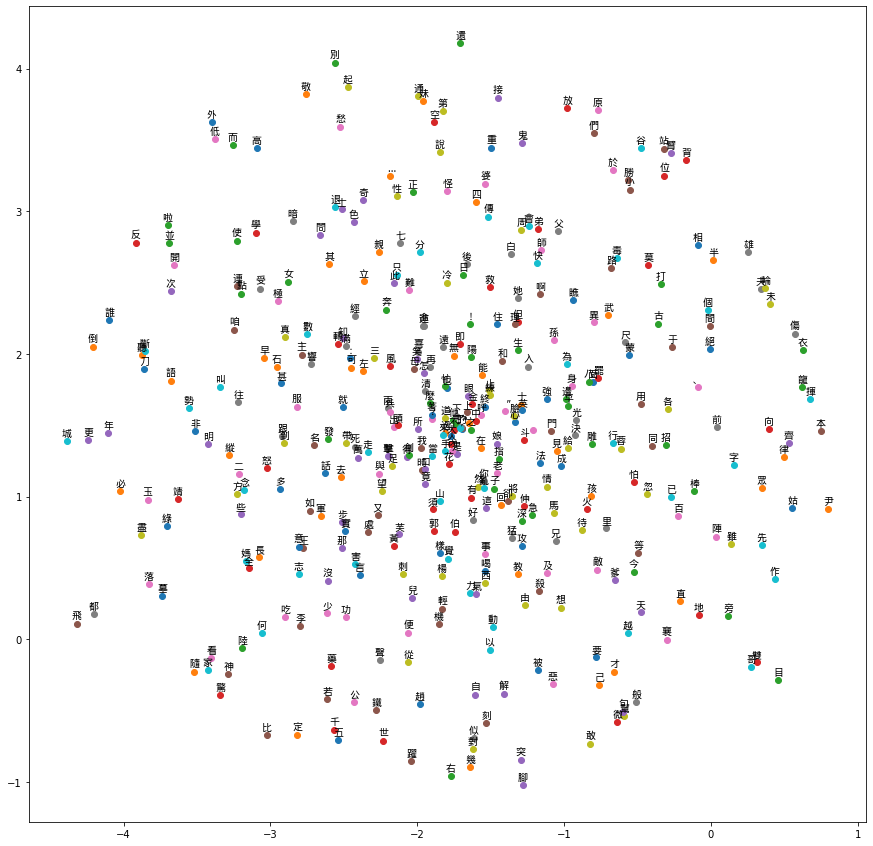

In [21]:
from sklearn.manifold import TSNE
from matplotlib import pylab

from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname='DroidSansFallbackFull.ttf')


num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(embedding[1:num_points+1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                        ha='right', va='bottom',fontproperties=myfont)
    pylab.show()

words = [id2word[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)